In [566]:
# import the requests module
import requests
# import pandas
import pandas as pd
# import numpy
import numpy as np
# import json normalize module
from pandas.io.json import json_normalize

# a variable for the API URL - note that we are using v2 - version 2
api_search_url = 'https://api.smk.dk/api/v1/art/search/?keys=sculpture&offset=0&rows=200&lang=en'

# retrieves the response for the URL and parameters we are sending
response = requests.get(api_search_url)

# print the response
print(response)
# the response is 200 - which means all is OK

# retrieve the JSON from the response variable and add to the json variable
json = response.json()

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


dic_flattened = [flatten_json(d) for d in json['items']]
df= json_normalize(dic_flattened)

<Response [200]>


In [567]:
#Show the amount of rows and columns in the entire dataframe
print(df.shape)

#Show the amount of cells in the dataframe
print(df.size)

(200, 249)
49800


249

In [568]:
df.drop(['acquisition_date', 'acquisition_date_precision','alternative_images_0_height','alternative_images_0_iiif_id'], inplace=True, axis=1)

In [569]:
# Remove coloumns that have don't have atleast 175 rows with non-Nan types
# This gives us an easy overview of columns that we could be interested in
df.dropna(axis=1, thresh=175,inplace=True)

In [570]:
df.dtypes

created                               object
credit_line_0                         object
frame_notes_0                         object
frame_notes_1                         object
has_image                               bool
id                                    object
iiif_manifest                         object
modified                              object
object_names_0_name                   object
object_number                         object
on_display                              bool
production_0_creator                  object
production_0_creator_date_of_birth    object
production_0_creator_lref             object
production_0_creator_nationality      object
production_date_0_end                 object
production_date_0_period              object
production_date_0_start               object
public_domain                           bool
responsible_department                object
rights                                object
titles_0_language                     object
titles_0_t

In [571]:
# Creating a new dataframe only consisting of the columns we want
nydf = df[["credit_line_0","has_image",'production_0_creator','production_0_creator_date_of_birth','production_0_creator_nationality','production_date_0_start','production_date_0_end','public_domain','titles_0_language','titles_0_title']]

In [572]:
# renaming columns to more fitting names
nydf.rename(columns={'credit_line_0':'creator','production_0_creator':'name','production_0_creator_date_of_birth':'birthyear','production_0_creator_nationality':'nationality','production_date_0_start':'py_start', 'production_date_0_end':'py_end','titles_0_language':'language','titles_0_title':'title'}, inplace=True)
nydf.head()

creator          object
has_image          bool
name             object
birthyear        object
nationality      object
py_start         object
py_end           object
public_domain      bool
language         object
title            object
dtype: object

In [573]:
# Slicing the data of coloumns with dates, to only have a year
nydf.loc[:, 'py_start'] = nydf['py_start'].str[:4]
nydf.loc[:, 'py_end'] = nydf['py_end'].str[:4]
nydf.loc[:, 'birthyear'] = nydf['birthyear'].str[:4]

# Slicing the © and 'space' away from the creator columns
nydf.loc[:, 'creator'] = nydf['creator'].str[2:]
nydf.head()

,creator,has_image,name,birthyear,nationality,py_start,py_end,public_domain,language,title
0,Kirsten Justesen,True,"Justesen, Kirsten",1943,dansk,1968,1968,True,da-DK,"""Sculpture two"""
1,Elisabeth Toubro,False,"Toubro, Elisabeth",1956,dansk,1992,1992,False,da-DK,"Uden titel, Metamorfoseskulptur 2"
2,Elisabeth Toubro,False,"Toubro, Elisabeth",1956,dansk,1992,1992,False,da-DK,"Uden titel, Metamorfoseskulptur 2"
3,Elisabeth Toubro,False,"Toubro, Elisabeth",1956,dansk,1992,1992,False,da-DK,"Uden titel, Metamorfoseskulptur 2"
4,Elisabeth Toubro,False,"Toubro, Elisabeth",1956,dansk,1992,1992,False,da-DK,"Uden titel, Metamorfoseskulptur 2"


In [574]:
# Changing datatype of 3 columns to numeric:
nydf.loc[:,'py_start'] = pd.to_numeric(nydf['py_start'])
nydf.loc[:,'py_end'] = pd.to_numeric(nydf['py_end'])
nydf.loc[:,'birthyear'] = pd.to_numeric(nydf['birthyear'])
nydf.dtypes

creator           object
has_image           bool
name              object
birthyear        float64
nationality       object
py_start         float64
py_end           float64
public_domain       bool
language          object
title             object
dtype: object

In [575]:
#Printing info about the languages
print('Amount of sculpture titles in a specific language:\n',nydf.language.value_counts())
print('Amount of sculptures without a specified language:\n',nydf.language.isna().sum())

Amount of sculpture titles in a specific language:
 da-DK    177
en-US      6
de-DE      2
fr-FR      2
Name: language, dtype: int64
Amount of sculptures without a specified language:
 13


In [576]:
# New dataframe with count of the artists' birthyear
dfb = pd.DataFrame(nydf['birthyear'].value_counts().reset_index().values,columns=['Birthyear',"Count"])
dfb = dfb.sort_index(axis = 0, ascending=True)
dfb = dfb.astype(int)


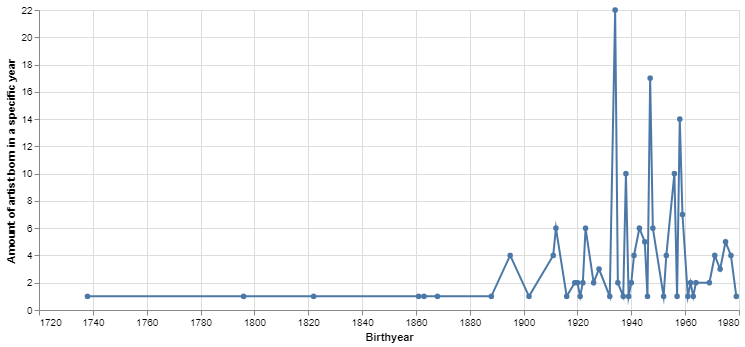

In [577]:
# import the altair code library
import altair as alt
alt.renderers.enable('notebook') # hvis I bruger Jupyter Notebook

# create a line plot
alt.Chart(dfb).mark_line(point=True).encode(
        # Birthyear on the X axis with encoding data type Q for quantitative and format c to display without decimal
        x=alt.X('Birthyear:Q', axis=alt.Axis(format='c', title='Birthyear')),
    
        # Number of artist born in a specific year on the Y axis  with encoding data type Q for quantitative
        y=alt.Y('Count:Q', axis=alt.Axis(title='Amount of artist born in a specific year')),
    
    # determine the width and hight  
    ).properties(width=700, height=300)

In [578]:
age_when_created = nydf.py_start - nydf.birthyear
nydf['Age_when_created'] = age_when_created
nydf.head()

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,creator,has_image,name,birthyear,nationality,py_start,py_end,public_domain,language,title,Age_when_created
0,Kirsten Justesen,True,"Justesen, Kirsten",1943.0,dansk,1968.0,1968.0,True,da-DK,"""Sculpture two""",25.0
1,Elisabeth Toubro,False,"Toubro, Elisabeth",1956.0,dansk,1992.0,1992.0,False,da-DK,"Uden titel, Metamorfoseskulptur 2",36.0
2,Elisabeth Toubro,False,"Toubro, Elisabeth",1956.0,dansk,1992.0,1992.0,False,da-DK,"Uden titel, Metamorfoseskulptur 2",36.0
3,Elisabeth Toubro,False,"Toubro, Elisabeth",1956.0,dansk,1992.0,1992.0,False,da-DK,"Uden titel, Metamorfoseskulptur 2",36.0
4,Elisabeth Toubro,False,"Toubro, Elisabeth",1956.0,dansk,1992.0,1992.0,False,da-DK,"Uden titel, Metamorfoseskulptur 2",36.0


In [579]:
# New dataframe with count of the artists' age when the sculpture was created
dfb = pd.DataFrame(nydf['Age_when_created'].value_counts().reset_index().values,columns=['Age_when_created',"Count"])
dfb = dfb.sort_index(axis = 0, ascending=True)
dfb = dfb.astype(int)
dfb

,Age_when_created,Count
0,68,19
1,36,17
2,37,13
3,58,11
4,35,9
5,26,6
6,56,5
7,32,5
8,38,5
9,41,5


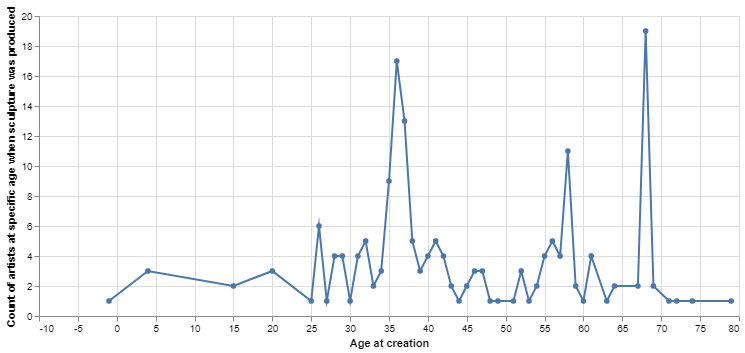

In [580]:
# create a line plot
alt.Chart(dfb).mark_line(point=True).encode(
        # Age_when_created on the X axis with encoding data type Q for quantitative and format c to display without decimal
        x=alt.X('Age_when_created:Q', axis=alt.Axis(format='c', title='Age at creation')),
    
        # Number of artist with a specific age when creating a sculpture on the Y axis  with encoding data type Q for quantitative
        y=alt.Y('Count:Q', axis=alt.Axis(title='Count of artists at specific age when sculpture was produced')),
    
    # determine the width and hight  
    ).properties(width=700, height=300)